In [1]:
import sys 
sys.path.append("../models/")
import statsmodels.api as sm 
from Basin import Basin 
from functions import plot_style
from import_functions import get_averted_deaths, import_posterior_dict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr
colors = plot_style("../fonts/Encode_Sans_Condensed/")

countries = np.array(['Indonesia', 'Bolivia', 'Morocco', 'Bangladesh', 'Sri Lanka', 'Kenya', 'Mozambique',
                      "Afghanistan", "Côte d'Ivoire", "Pakistan", "El Salvador", 
                      "Philippines", "Uganda", "Kyrgyzstan", "Egypt", "Rwanda", "Zambia", "Angola", "Ghana", "Honduras"])

end_date = datetime(2021, 10, 1)
start_date = datetime(2020, 12, 14)

In [2]:
def import_projections(country, scenario, IQR, baseline='data-driven'):

    # get averted deaths in perc
    avertedDeaths_perc = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=True)
    avertedDeaths_perc_med = np.median(avertedDeaths_perc)
    if IQR:

        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.25)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.75)
    else:
        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.05)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.95)

    # get averted deaths raw (without underreporting multiplier)
    avertedDeaths = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=False)
    avertedDeaths_med = np.median(avertedDeaths)

    # get averted deaths raw (with underreporting multiplier)
    avertedDeaths_scaled = get_averted_deaths(country, scenario, scaled=True, baseline=baseline, perc=False)
    avertedDeaths_scaled_med = np.median(avertedDeaths_scaled)

    return avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2, avertedDeaths_med, avertedDeaths_scaled_med
    

def plot_bar(ax, pos, med, q1, q2, color):
    ax.scatter([pos], [med], color=color, s=80, edgecolor='white', linewidth=0.7, zorder=1, marker="o")
    ax.plot([pos, pos], [q1, q2], color=color, solid_capstyle='round', linewidth=8, alpha=0.5, zorder=-1)


def barplot(scenario, IQR, country_title, baseline='data-driven', color=colors[0]):
    # get projections
    avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2 = np.zeros(len(countries)), np.zeros(len(countries)), np.zeros(len(countries))
    avertedDeaths_med, avertedDeaths_scaled_med = np.zeros(len(countries)), np.zeros(len(countries)) 

    for i in range(len(countries)):
        country = countries[i]
        perc_med, perc_q1, perc_q2, med, scaled_med = import_projections(country, scenario, IQR, baseline=baseline)
        avertedDeaths_perc_med[i] = perc_med
        avertedDeaths_perc_q1[i] = perc_q1
        avertedDeaths_perc_q2[i] = perc_q2
        avertedDeaths_med[i] = med
        avertedDeaths_scaled_med[i] = scaled_med

    # plot  
    fig, axes = plt.subplot_mosaic([["A", "A"], ["A", "A"]], dpi=300, figsize=(9,3))
    idx = np.argsort(avertedDeaths_perc_med)#[::-1]

    for i in range(len(idx)):
        plot_bar(axes["A"], i, avertedDeaths_perc_med[idx[i]], avertedDeaths_perc_q1[idx[i]], avertedDeaths_perc_q2[idx[i]], color)

        if avertedDeaths_med[idx[i]] < 1000:
            axes["A"].annotate(xy=(i, avertedDeaths_perc_q2[idx[i]]+2.7), text=str(np.round(avertedDeaths_med[idx[i]] / 1000, 1)) + "K", size=7, color="grey", ha="center")
        else:
            axes["A"].annotate(xy=(i, avertedDeaths_perc_q2[idx[i]]+2.7), text=str(int(avertedDeaths_med[idx[i]] / 1000)) + "K", size=7, color="grey", ha="center")

    axes["A"].set_xticks(range(len(idx)))
    axes["A"].set_xticklabels(countries[idx], rotation=90, size=8)
    axes["A"].set_ylabel("Averted Deaths (%)",  fontsize=8)
    axes["A"].set_title("Averted deaths starting vaccinations as {0}".format(country_title), weight="bold")

    for ax in axes.values():
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.grid(True, color='grey', linewidth=0.1, zorder=-1, linestyle="--")
        ax.set_axisbelow(True)
        ax.tick_params(axis="y", labelsize=8)

    file_name = "averted_deaths_" + scenario
    if IQR:
        file_name += "_IQR"

    plt.savefig("./img/" + file_name + ".pdf", bbox_inches="tight")
    return avertedDeaths_perc_med


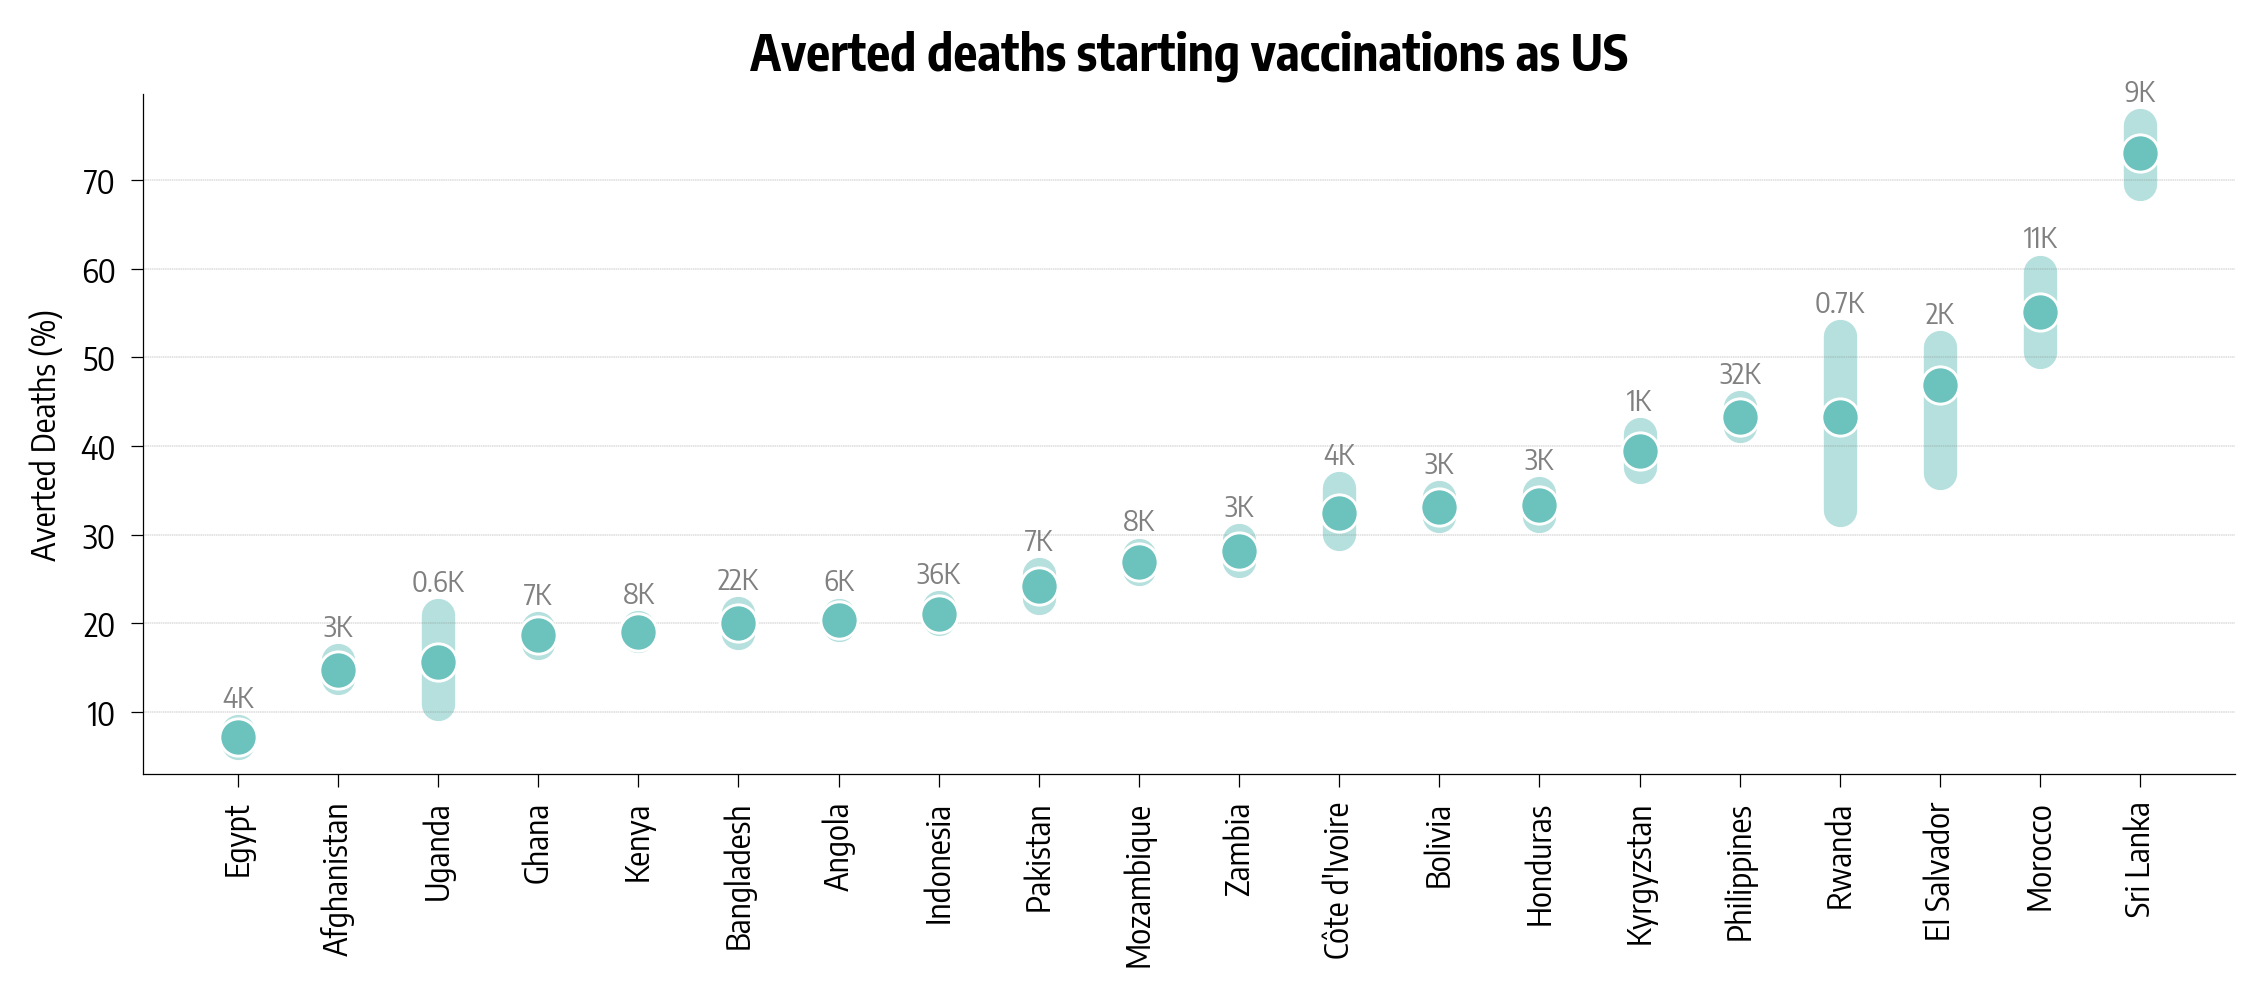

In [3]:
avertedDeaths_perc_med = barplot("us_start", IQR=True, baseline='data-driven', color=colors[0], country_title="US")

In [4]:
print('Averted Deaths %')
print(f'Min: {np.min(avertedDeaths_perc_med)}')
print(f'Max: {np.max(avertedDeaths_perc_med)}')
print(f'Average: {np.mean(avertedDeaths_perc_med)}')
print(f'Median: {np.median(avertedDeaths_perc_med)}')

Averted Deaths %
Min: 7.1442139137477385
Max: 73.07950903045386
Average: 30.819608612939724
Median: 27.577925810579096


In [5]:
avertedDeaths = get_averted_deaths('Sri Lanka', 'us_start', scaled=False, baseline='data-driven', perc=True, path='./projections_october/')
med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
print(f'Sri Lanka: {med}, IQR: [{q1}, {q2}]')

Sri Lanka: 73.07950903045386, IQR: [69.5172697117545, 76.20642901074527]


In [6]:
avertedDeaths = get_averted_deaths('Angola', 'us_start', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
print(f'Angola: {med}, IQR: [{q1}, {q2}]')

Angola: 6133.0, IQR: [4238.5, 8844.5]


In [7]:

avertedDeaths = get_averted_deaths('Zambia', 'us_start', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
print(f'Zambia: {med}, IQR: [{q1}, {q2}]')

Zambia: 3396.5, IQR: [2291.0, 4791.75]


In [8]:

avertedDeaths = get_averted_deaths('Indonesia', 'us_start', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
print(f'Indonesia: {med}, IQR: [{q1}, {q2}]')

Indonesia: 36247.5, IQR: [30014.5, 46139.75]


In [9]:


avertedDeaths = get_averted_deaths('Bangladesh', 'us_start', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
print(f'Bangladesh: {med}, IQR: [{q1}, {q2}]')

Bangladesh: 22023.5, IQR: [15049.75, 33488.25]
